In [16]:
import json
import os
from typing import List, Dict
import numpy as np
import networkx as nx
from gtda.homology import FlagserPersistence
from gtda.diagrams import BettiCurve
import matplotlib.pyplot as plt
import gudhi as gd
from gtda.plotting import plot_diagram


In [17]:
def load_game_data(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as file:
        game_data = json.load(file)
    return game_data


In [18]:
def construct_adjacency_matrix(game: List[Dict]) -> nx.Graph:
    G = nx.Graph()

    counts = [pass_info["count"] for player in game for pass_info in player["passes"]]
    max_count = max(counts)
    min_count = min(counts)

    for player in game:
        G.add_node(player['name'], pos=(player['x'], player['y']))

    for player in game:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]

            edge_weight = 1 - (count - min_count) / (max_count - min_count)

            edge_weight = round(edge_weight, 3)

            G.add_edge(player1, player2, weight=edge_weight)

    return G



def visualize_passing_network(G):
    pos = nx.get_node_attributes(G, 'pos')
    weights =nx.get_edge_attributes(G, 'weight').values()
    
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=list(weights), edge_color='gray')
    plt.title("Passing Network Graph")
    plt.axis('off')
    plt.show()
    

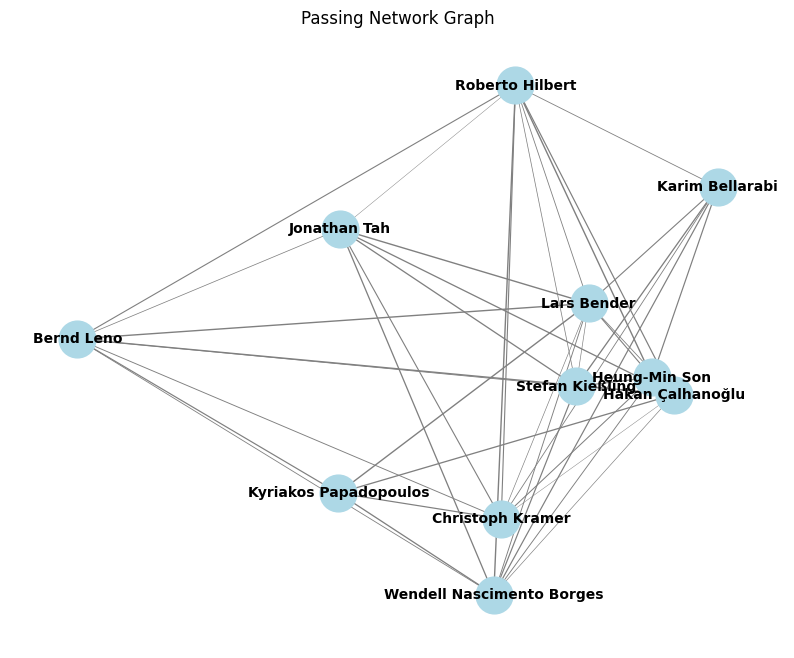

In [19]:
example_game = load_game_data('../data/2015-2016/1-Bundesliga/3890260_Bayer-Leverkusen_1_59.json')

G_example = construct_adjacency_matrix(example_game)
visualize_passing_network(G_example)

In [20]:
def graph_to_adjacency_matrix(G):
    nodes = sorted(G.nodes())
    adj_matrix_noinf = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    adj_matrix = np.where(adj_matrix_noinf == 0, np.inf, adj_matrix_noinf)
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix, nodes

In [21]:
adj_matrix, nodes = graph_to_adjacency_matrix(G_example)
print("Adjacency Matrix:")
print(adj_matrix)
print("\nNodes Order:")
print(nodes)

Adjacency Matrix:
[[0.    0.667 1.      inf 0.533   inf 0.867 1.    0.8   0.6   0.6  ]
 [0.667 0.    0.333 0.733 0.8   0.6   0.867 0.467 0.8     inf   inf]
 [1.    0.333 0.    0.733 0.933   inf 0.933 0.6   0.867 0.267 0.467]
 [  inf 0.733 0.733 0.      inf 0.867   inf 0.8   1.    0.8   0.667]
 [0.533 0.8   0.933   inf 0.      inf   inf 1.    0.333 0.933 0.933]
 [  inf 0.6     inf 0.867   inf 0.      inf 0.8   0.6   0.933 0.867]
 [0.867 0.867 0.933   inf   inf   inf 0.    1.      inf   inf 0.933]
 [1.    0.467 0.6   0.8   1.    0.8   1.    0.    0.6   0.467 0.667]
 [0.8   0.8   0.867 1.    0.333 0.6     inf 0.6   0.    0.533 1.   ]
 [0.6     inf 0.267 0.8   0.933 0.933   inf 0.467 0.533 0.    0.867]
 [0.6     inf 0.467 0.667 0.933 0.867 0.933 0.667 1.    0.867 0.   ]]

Nodes Order:
['Bernd Leno', 'Christoph Kramer', 'Hakan Çalhanoğlu', 'Heung-Min Son', 'Jonathan Tah', 'Karim Bellarabi', 'Kyriakos Papadopoulos', 'Lars Bender', 'Roberto Hilbert', 'Stefan Kießling', 'Wendell Nascimento Bor

In [22]:
fp = FlagserPersistence()

diagrams = fp.fit_transform([adj_matrix])[0]

plot_diagram(diagrams)

In [23]:
print(diagrams)

[[0.         0.26699999 0.        ]
 [0.         0.333      0.        ]
 [0.         0.333      0.        ]
 [0.         0.46700001 0.        ]
 [0.         0.46700001 0.        ]
 [0.         0.53299999 0.        ]
 [0.         0.53299999 0.        ]
 [0.         0.60000002 0.        ]
 [0.         0.667      0.        ]
 [0.         0.86699998 0.        ]
 [0.667      0.80000001 1.        ]
 [0.667      0.80000001 1.        ]
 [0.667      0.73299998 1.        ]
 [0.60000002 0.80000001 1.        ]
 [0.60000002 0.80000001 1.        ]
 [0.60000002 0.80000001 1.        ]
 [0.60000002 0.80000001 1.        ]
 [0.60000002 0.80000001 1.        ]
 [0.60000002 0.86699998 1.        ]
 [0.60000002 0.86699998 1.        ]
 [0.53299999 0.80000001 1.        ]
 [0.53299999 0.60000002 1.        ]
 [0.46700001 0.60000002 1.        ]
 [0.46700001 0.60000002 1.        ]
 [0.46700001 0.60000002 1.        ]
 [0.46700001 0.667      1.        ]
 [0.333      0.60000002 1.        ]
 [0.333      0.80000001 1.  

In [24]:
# Function to compute average persistence and standard deviation for Betti0 (H0) and Betti1 (H1)
def compute_persistence_stats(diagrams):
    diagrams = np.array(diagrams)
    
    # Separate Betti0 (H0) and Betti1 (H1)
    h0_data = diagrams[diagrams[:, 2] == 0]
    h1_data = diagrams[diagrams[:, 2] == 1]
    
    # Compute persistence (Death - Birth)
    persistence_h0 = h0_data[:, 1] - h0_data[:, 0]
    persistence_h1 = h1_data[:, 1] - h1_data[:, 0]
    
    # Compute average and standard deviation
    avg_h0 = np.mean(persistence_h0) if len(persistence_h0) > 0 else 0
    std_h0 = np.std(persistence_h0) if len(persistence_h0) > 0 else 0
    avg_h1 = np.mean(persistence_h1) if len(persistence_h1) > 0 else 0
    std_h1 = np.std(persistence_h1) if len(persistence_h1) > 0 else 0
    
    return {
        "Average H0": avg_h0,
        "Std H0": std_h0,
        "Average H1": avg_h1,
        "Std H1": std_h1
    }

# Calculate persistence statistics
persistence_stats = compute_persistence_stats(diagrams)
persistence_stats


{'Average H0': 0.506700000166893,
 'Std H0': 0.16927849577226722,
 'Average H1': 0.20347368560339274,
 'Std H1': 0.09313112690177573}

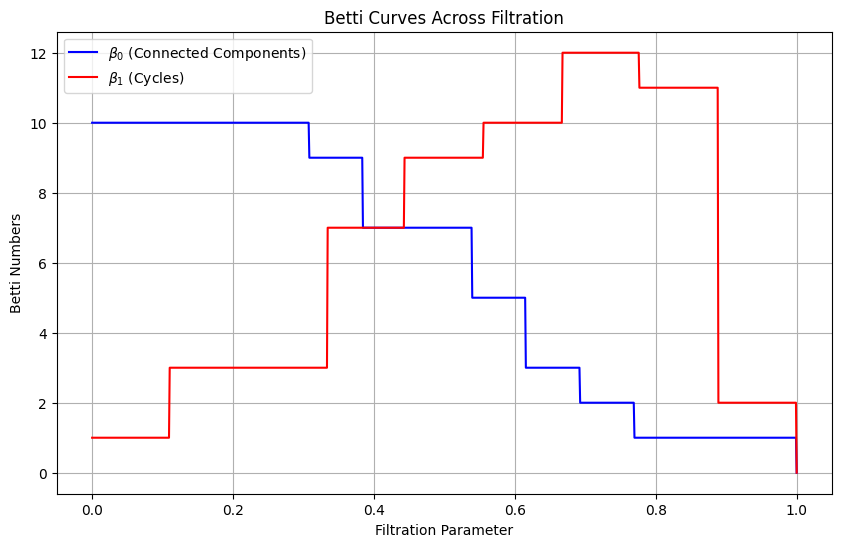

In [25]:
betti_transformer = BettiCurve(n_bins=1000)
betti_numbers = betti_transformer.fit_transform([diagrams])[0]

filtration_values = np.linspace(0, 1, num=1000)


betti0 = betti_numbers[0, :]
betti1 = betti_numbers[1, :] if betti_numbers.shape[0] > 1 else None

plt.figure(figsize=(10, 6))
plt.plot(filtration_values, betti0, label=r'$\beta_0$ (Connected Components)', color='blue')
if betti1 is not None:
    plt.plot(filtration_values, betti1, label=r'$\beta_1$ (Cycles)', color='red')
plt.xlabel('Filtration Parameter')
plt.ylabel('Betti Numbers')
plt.title('Betti Curves Across Filtration')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
auc_betti0 = np.trapz(betti0, filtration_values)
auc_betti1 = np.trapz(betti1, filtration_values) if betti1 is not None else 0
print(f"AUC β0: {auc_betti0}, AUC β1: {auc_betti1}")

AUC β0: 5.844844844844844, AUC β1: 6.44094094094094
